In [1]:
import pandas as pd
import pickle
from modules.process_data import *
from modules.utils import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import scanpy as sc
from tqdm import tqdm
from modules.dea import *
from harmony import harmonize
import harmonypy as hm
scaler = StandardScaler()

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-11 09:59:01.030652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-11 09:59:01.583692: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Import data

In [2]:
#dataset = "run"
dataset = 'scdi'

In [3]:
if dataset == "run":
    adata1 = anndata.read_h5ad("data/A_count.h5ad")
    adata1.obs['Sample_Tag'] = 'LD_5xFAD'
    adata2 = anndata.read_h5ad("data/B_count.h5ad")
    adata2.obs['Sample_Tag'] = 'LD_NC'
    adata = anndata.concat([adata1, adata2], axis=0)
    anno_df1 = pd.read_csv("data/A_mapping.csv", skiprows=4)
    anno_df2 = pd.read_csv("data/B_mapping.csv", skiprows=4)
    anno_df = pd.concat([anno_df1, anno_df2])
    
    tag1 = 'LD_NC'
    tag2 = 'LD_5xFAD'
    
elif dataset == "scdi":
    adata = anndata.read_h5ad("data/fede_count.h5ad")
    anno_df = pd.read_csv("data/fede_mapping.csv", skiprows=4)
    
    tag1 = 'SampleTag17_flex'
    tag2 = 'SampleTag18_flex'
    tag3 = 'SampleTag19_flex'
    tag4 = 'SampleTag20_flex'

# Process data

In [4]:
adata = rm_high_mt(adata, threshold=0.5)
adata = filter_cells_by_gene_counts(adata)
adata = rm_low_exp(adata, threshold=0.01)
#TODO: keep if more than 3 cnt
sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/scanpy/preprocessing/_normalization.py:206: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [5]:
#join sample tag to df
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sc_df = sc_df.join(sample_tags)

In [6]:
#drop multiplets and undetermined
#sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet'])]

In [7]:
#creating annotation df
anno_df = anno_df.set_index('cell_id')[['class_name', "subclass_name", "supertype_name", 'cluster_name']]

In [8]:
#ensure index is type int
sc_df.index = sc_df.index.astype('int64')
anno_df.index = anno_df.index.astype('int64')

In [9]:
#merge expression matrix and annotation
sc_df = sc_df.join(anno_df)

# Select conditions to analyze

In [ ]:
#extract specific type
#sc_df = sc_df[sc_df['class_name'].isin(['30 Astro-Epen'])]

# Type analysis

In [10]:
X = sc_df.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1).values
Y = sc_df['class_name'].values
#Y_ = sc_df['subclass_name'].values

In [11]:
unique_targets = [x for x in Counter(Y)]
palette = sns.color_palette('Set3', 12) + sns.color_palette('Paired', 12) + sns.color_palette('Set2', 10)
color_mapping = {target: palette[i] for i, target in enumerate(unique_targets)}

In [33]:
components = 8
pca = PCA(n_components=components)

In [34]:
X = scaler.fit_transform(X)
X_pca = pca.fit_transform(X)

In [35]:
#Run harmony
combined_data = np.vstack([X_pca])
metadata = pd.DataFrame({'batch': ['batch1'] * X_pca.shape[0]})
harmony_output = hm.run_harmony(combined_data, metadata, vars_use=['batch'])
harmonized_data = harmony_output.Z_corr.T
harmonized_X = harmonized_data[:X_pca.shape[0], :]

2024-06-11 10:16:35,832 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2024-06-11 10:16:37,095 - harmonypy - INFO - sklearn.KMeans initialization complete.
2024-06-11 10:16:37,128 - harmonypy - INFO - Iteration 1 of 10
2024-06-11 10:16:38,186 - harmonypy - INFO - Iteration 2 of 10
2024-06-11 10:16:39,285 - harmonypy - INFO - Iteration 3 of 10
2024-06-11 10:16:40,407 - harmonypy - INFO - Iteration 4 of 10
2024-06-11 10:16:41,497 - harmonypy - INFO - Iteration 5 of 10
2024-06-11 10:16:42,579 - harmonypy - INFO - Iteration 6 of 10
2024-06-11 10:16:43,087 - harmonypy - INFO - Converged after 6 iterations


In [ ]:
n_neighbors_list = [50, 75, 100, 150]
plot_umaps(harmonized_X, Y, n_neighbors_list, color_mapping, min_count=100, classes_to_plot=None)

In [36]:
#umap
umap = UMAP(n_neighbors=100, n_components=2, n_jobs=-1)
X_umap = umap.fit_transform(harmonized_X)

In [40]:
X_umap

array([[10.783999  , 10.961562  ],
       [ 3.9718738 ,  1.0721955 ],
       [-3.3217125 ,  0.6504618 ],
       ...,
       [ 6.918741  ,  2.5884874 ],
       [-5.0516434 ,  0.44196782],
       [ 1.9693621 ,  1.0494667 ]], dtype=float32)

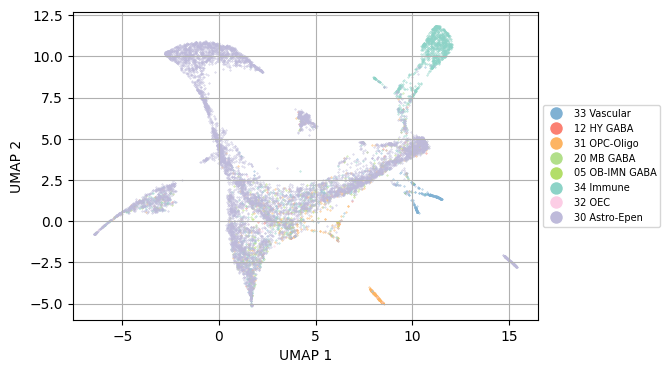

In [39]:
plot_umap(X_umap, Y, color_mapping, min_count=100, classes_to_plot=None)

In [38]:
def plot_umap(X, Y, color_mapping, min_count=100, classes_to_plot=None):
    plt.figure(figsize=(6, 4))
    markersize_scatter = 0.1  
    markersize_legend = 10

    # Calculate the counts of each target
    target_counts = Counter(Y)
    
    # Filter unique targets based on the minimum count threshold
    filtered_targets = [target for target in set(Y) if target_counts[target] >= min_count]

    # If classes_to_plot is provided, only keep those classes
    if classes_to_plot is not None:
        class_id = [x.split(' ')[0] for x in filtered_targets]
        filtered_targets = [target for target in filtered_targets if target.split(' ')[0] in classes_to_plot]


    for target in filtered_targets:
        indices = np.where(Y == target)
        color = color_mapping.get(target, 'black')  # Default to black if the target is not found in the mapping
        plt.scatter(X[indices, 0], X[indices, 1], color=color, label=target, s=markersize_scatter)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')

    handles = [Line2D([0], [0], marker='o', color='w', markerfacecolor=color_mapping.get(target, 'black'), markersize=markersize_legend, label=target)
               for target in filtered_targets]

    plt.legend(handles=handles, loc='center left', bbox_to_anchor=(1, 0.5), fontsize=7)
    plt.grid(True)
    plt.show()

# Differential expression analysis

In [ ]:
sc_df1 = sc_df1.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)
sc_df2 = sc_df2.drop(['Sample_Tag', 'class_name', "subclass_name", "supertype_name", 'cluster_name'], axis=1)

In [ ]:
#DEA
results_df = differential_expression_analysis(sc_df1, sc_df2)

In [ ]:
#volcano_plot
significant = get_volcano_plot(results_df, min_fold_change=0.25, max_p_value=0.05)

In [ ]:
get_heatmap(results_df, sc_df1, sc_df2)

# GO enrichment analysis

In [ ]:
dump_deg(results_df)

In [ ]:
#process_df_and_plot('DEG/analysis(21).txt')

In [ ]:
#process_df_and_plot('DEG/analysis(20).txt')

In [ ]:
objanno = Gene2GoReader("/path/to/gene2go", taxids=[10090])

In [ ]:
from goatools.obo_parser import GODag
from goatools.anno.genetogo_reader import Gene2GoReader
from goatools.test_data.genes_NCBI_10090_ProteinCoding import GENEID2NT as MOUSE_GENEID2NT
from goatools.goea.go_enrichment_ns import GOEnrichmentStudyNS

def perform_go_enrichment(gene_list, background_genes):
    # Load the GO DAG
    obodag = GODag("DEG/go-basic.obo")

    # Load the gene to GO mapping for mouse
    objanno = Gene2GoReader("DEG/gene2go", taxids=[10090])

    # Get the namespace2association for mouse
    ns2assoc = objanno.get_ns2assc()

    # Create a GOEA object
    goeaobj = GOEnrichmentStudyNS(
        background_genes, # Background gene set
        ns2assoc, # geneid/GO associations
        obodag, # Ontologies
        propagate_counts = False,
        alpha = 0.05, # default significance cut-off
        methods = ['fdr_bh'] # defult multipletest correction method
    )

    # Run the GOEA and get significant results
    goea_results_all = goeaobj.run_study(gene_list)
    goea_results_sig = [r for r in goea_results_all if r.p_fdr_bh < 0.05]

    # Convert the results to a DataFrame
    df_results = pd.DataFrame([r.__dict__ for r in goea_results_sig])

    return df_results

In [ ]:
positive_deg = results_df[(results_df["pval_corrected"] < 0.05) & (results_df["log2foldchange"] > 0.25)]['gene'].tolist()
#positive_deg = [x.upper() for x in positive_deg]

negative_deg = results_df[(results_df["pval_corrected"] < 0.05) & (results_df["log2foldchange"] <= -0.25)]['gene'].tolist()
#negative_deg = [x.upper() for x in negative_deg]

In [ ]:
reference_list = [x.upper() for x in sc_df1.columns.values.tolist()]
reference_list = [x for x in sc_df1.columns.values.tolist()]

In [ ]:
import mygene

# Initialize MyGene.info
mg = mygene.MyGeneInfo()

# Example gene list
gene_symbols = positive_deg

# Query MyGene.info to get NCBI Gene IDs
gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='entrezgene', species='mouse')

# Extract NCBI Gene IDs
gene_list_ncbi = [entry.get('entrezgene') for entry in gene_info if 'entrezgene' in entry]

# Repeat for background genes if they are also in string format
background_genes_symbols = reference_list
background_gene_info = mg.querymany(background_genes_symbols, scopes='symbol', fields='entrezgene', species='mouse')
background_genes_ncbi = [entry.get('entrezgene') for entry in background_gene_info if 'entrezgene' in entry]

In [ ]:
len(background_genes_ncbi)

In [ ]:
len(gene_list_ncbi)

In [ ]:
df_results = perform_go_enrichment(gene_list_ncbi, background_genes_ncbi)